In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
from aifeel.util.evaluate import evaluate_model
import dill
from aifeel.model.nn import NNClassifier

# Evaluate Each Model

In [22]:
# Load the model from the file
with open("export/model/NNClassifier/model.dill", "rb") as f:
    loaded_model = dill.load(f)

with open("export/model/NNClassifier/vectorizer.dill", "rb") as f:
    vectorizer = dill.load(f)

Epoch 1/10
810/810 [==============================] - 6s 7ms/step - loss: 0.3465 - accuracy: 0.8542 - val_loss: 0.2194 - val_accuracy: 0.9073
Epoch 2/10
810/810 [==============================] - 6s 7ms/step - loss: 0.2040 - accuracy: 0.9175 - val_loss: 0.1850 - val_accuracy: 0.9281
Epoch 3/10
810/810 [==============================] - 5s 7ms/step - loss: 0.1782 - accuracy: 0.9291 - val_loss: 0.1752 - val_accuracy: 0.9312
Epoch 4/10
810/810 [==============================] - 5s 6ms/step - loss: 0.1636 - accuracy: 0.9355 - val_loss: 0.1703 - val_accuracy: 0.9361
Epoch 5/10
810/810 [==============================] - 5s 6ms/step - loss: 0.1531 - accuracy: 0.9393 - val_loss: 0.1692 - val_accuracy: 0.9358
Epoch 6/10
810/810 [==============================] - 5s 6ms/step - loss: 0.1450 - accuracy: 0.9441 - val_loss: 0.1694 - val_accuracy: 0.9351
Epoch 7/10
810/810 [==============================] - 5s 6ms/step - loss: 0.1336 - accuracy: 0.9481 - val_loss: 0.1665 - val_accuracy: 0.9368
Epoch 

NNClassifier Evaluation:

Cross-Validation Scores: [0.94125   0.9334375 0.94125   0.945625  0.93875   0.94375   0.9403125
 0.941875  0.939375  0.941875 ]

Cross-Validation Average Score: 0.94

Accuracy Scores: 0.936625

Classification Report:

precision    recall  f1-score   support

           0       0.93      0.94      0.94      4000
           1       0.94      0.93      0.94      4000

    accuracy                           0.94      8000
   macro avg       0.94      0.94      0.94      8000
weighted avg       0.94      0.94      0.94      8000

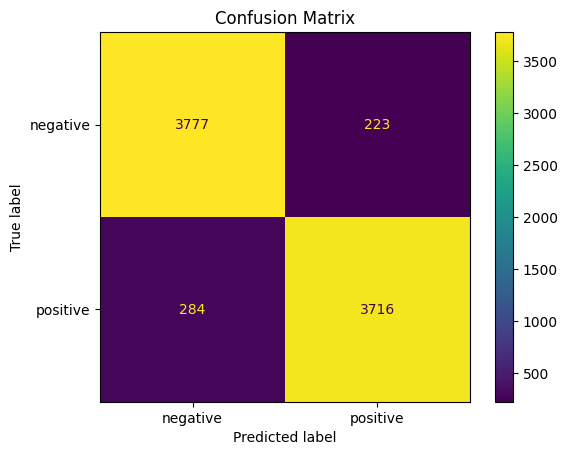

250/250 [==============================] - 1s 2ms/step


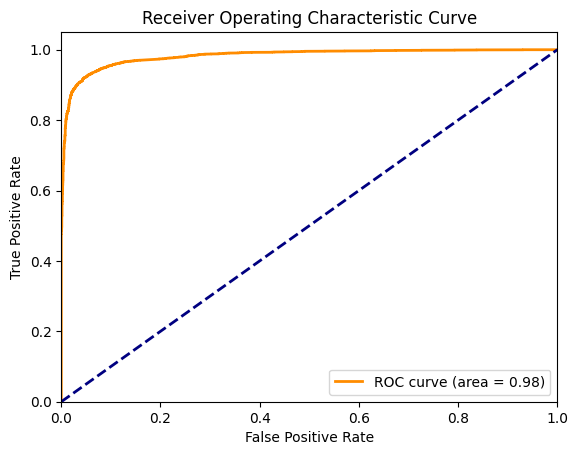

In [23]:
data = np.load('export/model/NNClassifier/data.npz')

# Access the arrays stored in the .npz file
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

evaluate_model(NNClassifier(epochs=10, batch_size=32, lr=0.0001),loaded_model,"NNClassifier",X_train,y_train,X_test,y_test)